In [1]:

import os
import logging
from io import BytesIO
from collections import Counter
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns



from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix







## CNNModel

The `CNNModel` class defines the architecture of the CNN used for classifying candlestick patterns:

- **Convolutional Layers**: Sequential convolutional layers with ReLU activation extract spatial features from input images. Max-pooling layers downsample the feature maps, reducing dimensionality while retaining key features. These layers create a hierarchical understanding of candlestick patterns.

- **Dynamic Flattening**: A utility function `_calculate_flattened_size` dynamically computes the size of the flattened tensor after the convolutional layers, ensuring flexibility for varying input dimensions.

- **Fully Connected Layers**: These layers classify the extracted features into one of three classes: `Buy`, `Sell`, or `No_Trade`. Dropout layers mitigate overfitting by randomly deactivating neurons during training.

**Role**: The `CNNModel` class acts as the backbone of the solution, learning the mapping from candlestick chart images to trading signals, as outlined in relevant references.


In [2]:


class CNNModel(nn.Module):
    def __init__(self, input_size=(3, 128, 128)):
        """
        CNN Model for candlestick pattern classification. Initialize the model with convolutional and fully connected layers.
        
        """
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dynamically calculate the flattened size after convolutional layers
        self.flattened_size = self._calculate_flattened_size(input_size)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 256),  # Dynamically calculated size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)  # 3 classes: Buy, Sell, No Trade
        )

    def _calculate_flattened_size(self, input_size):
        """
        Calculate the output size of the convolutional layers for a given input size.

    
        """
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)  # Create a dummy input tensor
            output = self.conv_layers(dummy_input)
            return output.numel()  # Total number of elements in the output

    def forward(self, x):
        """
        Forward pass through the model.

        """
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x



    def train_model(image_dir, model_save_path, epochs=10, batch_size=32, lr=0.001):
        """
        Train the CNN model for candlestick pattern classification.

        """
        # Load dataset to calculate mean and std
        raw_dataset = datasets.ImageFolder(root=image_dir, transform=transforms.ToTensor())
        raw_loader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=False)

        # Calculate mean and std of the dataset
        mean = 0.0
        std = 0.0
        n_samples = 0
        for images, _ in raw_loader:
            n_samples += images.size(0)
            mean += images.mean([0, 2, 3]) * images.size(0)
            std += images.std([0, 2, 3]) * images.size(0)

        mean /= n_samples
        std /= n_samples

        print(f"Dataset Mean: {mean.tolist()}, Dataset Std: {std.tolist()}")

        # Image transformations with computed mean and std
        # this is used in the training and validation data loaders via datasets.ImageFolder
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean.tolist(), std=std.tolist())
        ])

        
        dataset = datasets.ImageFolder(root=image_dir, transform=transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        # if cudea is available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = CNNModel().to(device)

        #  class weights for balancing
        # stackoverflow.com/questions/55579610/weight-parameter-in-pytorch-crossentropyloss
        
        class_counts = Counter(dataset.targets)
        total_samples = sum(class_counts.values())
        class_weights = [total_samples / max(class_counts.get(c, 1), 1) for c in range(len(class_counts))]
        weights = torch.tensor(class_weights, dtype=torch.float).to(device)

       # Loss, optimizer, and scheduler
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        
        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            # metrics
            val_accuracy = correct / total
            class_distribution = Counter(all_preds)

            # Print metrics and diagnostics
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss / len(train_loader):.4f}")
            print(f"  Val Loss: {val_loss / len(val_loader):.4f}")
            print(f"  Val Accuracy: {val_accuracy:.2%}")
            print(f"  Class Distribution: {class_distribution}")

            # variable learning rate
            scheduler.step()

       
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")
        return model


## CNNCandlestick

The `CNNCandlestick` class provides an end-to-end interface for applying the `CNNModel` to real-world candlestick data. Its functionality includes:

- **Data Preparation**: Raw OHLC data is sliced into windows, generating candlestick charts as images using `mplfinance`. These charts are preprocessed into tensors for model inference using `torchvision.transforms`.

- **Pattern Detection**: The `detect_patterns` method applies the trained `CNNModel` to identify `Buy`, `Sell`, or `No_Trade` signals based on confidence thresholds. Confidence scores are logged for debugging and analysis.

- **Backtesting**: The `backtest` method evaluates the profitability of detected signals by calculating Profit and Loss (PnL) based on historical prices. This method simulates trading based on detected patterns, providing insights into the model’s performance.

- **Visualization**: Functions plot detected signals on candlestick charts, enhancing interpretability.

-**Debugging**: Logging has been used to understand the behaviour and some defensive programming employed to understand the various problems associsated with it.

In [3]:


class CNN_Candlestick:
    def __init__(self, ticker_data, model, transform, device, charts_dir):
        self.ticker_data = ticker_data
        self.model = model
        self.transform = transform
        self.device = device
        self.charts_dir = charts_dir
        self.trades = []
        self.pnl = 0
        self.class_mapping = {0: "Buy", 1: "No_Trade", 2: "Sell"}

    def detect_patterns(self, cnn_window=10, batch_size=10, ticker=None):
        """
        Detect patterns using batches of non-overlapping windows of cnn_window size to avoid duplication 
        """
        if not ticker:
            raise ValueError("Ticker must be provided.")

        self.model.eval()
        unique_trades = {}  # Dictionary to track unique trades by (date, price, signal)
        processed_trades = set()  # Track processed trades to avoid duplication

        batch_inputs = []
        batch_indices = []

        # Iterate through non-overlapping windows
        for i in range(cnn_window, len(self.ticker_data), cnn_window):
            # Extract non-overlapping cnn_window slices
            data_window = self.ticker_data.iloc[i - cnn_window:i]

            # Use the last day of the window for the signal date and price
            date = self.ticker_data.index[i - 1]
            price = self.ticker_data.iloc[i - 1]["Close"]

            # Avoid duplicate processing for (date, price)
            if (date, price) in processed_trades:
                logging.info(f"Duplicate trade ignored: Date={date}, Price={price}")
                continue

            processed_trades.add((date, price))

            # Generate the candlestick chart for this window
            chart_image = self._generate_candlestick_chart(data_window)
            if chart_image is None:
                continue

            # Transform the image and append it to the batch
            input_tensor = self.transform(chart_image).unsqueeze(0)
            batch_inputs.append(input_tensor)
            batch_indices.append((i, date, price))

            # Process the batch once it reaches the required size
            if len(batch_inputs) >= batch_size:
                self._process_batch(batch_inputs, batch_indices, ticker, cnn_window=cnn_window)
                batch_inputs = []
                batch_indices = []

        # Process any remaining inputs in the final batch
        if batch_inputs:
            self._process_batch(batch_inputs, batch_indices, ticker, cnn_window=cnn_window)
        
        logging.info(f"Processing ticker: {ticker}")
        logging.info(f"Finished detecting patterns. Total trades: {len(self.trades)}")
        logging.info(f"Trade distribution: {Counter([trade['Signal'] for trade in self.trades])}")






    def _process_batch(self, batch_inputs, batch_indices, ticker, cnn_window=10):
        """
        Process a batch of inputs using normalized logits with softmax and class-specific confidence thresholds.
        """
        # Combine inputs into a single tensor and move to device
        batch_inputs = torch.cat(batch_inputs).to(self.device)

        # Perform inference without gradients
        with torch.no_grad():
            outputs = self.model(batch_inputs)  # Raw logits

            # Normalize logits within each class
            mean = outputs.mean(dim=1, keepdim=True)
            std = outputs.std(dim=1, keepdim=True)
            normalized_logits = (outputs - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero

            # Apply softmax to normalized logits
            predictions = torch.softmax(normalized_logits, dim=1).cpu().numpy()

        # Visualize batch probabilities after normalization
        logging.info("Batch probabilities after normalization:")
        for idx, confidence_scores in enumerate(predictions):
            logging.info(f"  Sample {idx + 1}: Buy={confidence_scores[0]:.3f}, No_Trade={confidence_scores[1]:.3f}, Sell={confidence_scores[2]:.3f}")

        # Define class-specific confidence thresholds
        class_thresholds = {"Buy": 0.45, "Sell": 0.10, "No_Trade": 0.65}
        for batch_index, ((window_index, date, price), confidence_scores) in enumerate(zip(batch_indices, predictions)):    
            # Ensure window_index is properly unpacked and validated
            try:
                window_index = int(window_index)  # Explicitly ensure integer type
            except ValueError as e:
                logging.error(f"Invalid window_index: {window_index} (type: {type(window_index)}). Error: {e}")
                continue
        
        #     # Ensure window_index is properly unpacked and validated
        #     if not isinstance(window_index, int):
        #         logging.error(f"Invalid window_index: {window_index} (type: {type(window_index)})")
        #         continue

            # Prioritize Buy and Sell
            if confidence_scores[2] >= class_thresholds["Sell"]:  # Sell priority
                predicted_class = 2
            elif confidence_scores[0] >= class_thresholds["Buy"]:  # No_Trade priority
                predicted_class = 0
            else:  # Default to No_Trade
                predicted_class = 1
                
            
            predicted_signal = self.class_mapping[predicted_class]
            confidence = confidence_scores[predicted_class]  # Use normalized softmax probability as confidence

            # Log normalized logits and probabilities
            logging.info(f"Processing batch for ticker: {ticker}")
            logging.info(f"Normalized logits: {normalized_logits[batch_index]}")
            logging.info(f"Softmax probabilities: {confidence_scores}")
            logging.info(f"Predicted class: {predicted_class}, Signal: {predicted_signal}, Confidence: {confidence}")

            # Skip predictions below the class-specific confidence threshold
            if confidence <= class_thresholds[predicted_signal]:
                logging.info(f"Skipped due to low confidence: {confidence} for {predicted_signal}")
                continue

            # Append the trade
            self.trades.append({"Ticker": ticker, "Date": date, "Signal": predicted_signal, "Price": price})
            logging.info(f"Added trade: {predicted_signal} at {date}, Price: {price}")
            # Generate charts for actionable signals
            #if predicted_signal in ["Buy", "Sell", "No_Trade"]:
            self._generate_and_save_chart(ticker, predicted_signal, date, price, window_index, cnn_window)


    def _generate_and_save_chart(self, ticker, signal, date, price, window_index, cnn_window):
        """
        Generate and save a candlestick chart for a specific trade signal.
        """
        try:
            # Validate and ensure proper types
            if not isinstance(window_index, int) or not isinstance(cnn_window, int):
                raise TypeError(f"window_index and cnn_window must be integers. Got {type(window_index)} and {type(cnn_window)}")

            sanitized_date = date.strftime("%Y-%m-%d_%H-%M-%S")
            # chart_path = os.path.join(self.charts_dir, f"{ticker}_{signal}_{sanitized_date}_{price:.2f}.png")
            signal_dir = os.path.join(self.charts_dir, signal)
            os.makedirs(signal_dir, exist_ok=True)
            chart_path = os.path.join(signal_dir, f"{ticker}_{signal}_{sanitized_date}_{price:.2f}.png")


            logging.info(f"Generating chart for window_index: {window_index}, cnn_window: {cnn_window}")

            # Ensure valid slicing for candlestick chart generation
            start_idx = max(0, window_index - cnn_window)  # Handle edge cases where slicing would go out of bounds
            end_idx = window_index
            chart_image = self._generate_candlestick_chart(self.ticker_data.iloc[start_idx:end_idx])

            if chart_image:
                chart_image.save(chart_path)
                logging.info(f"Chart saved: {chart_path}")
            else:
                logging.error(f"Failed to generate chart: Empty chart image for {ticker} at {date}")

        except TypeError as te:
            logging.error(f"TypeError in chart generation: {te} for ticker {ticker} at {date}")
        except Exception as e:
            logging.error(f"Unexpected error during chart generation: {e} for ticker {ticker} at {date}")





    def _generate_candlestick_chart(self, data):
        buffer = BytesIO()
        try:
            mpf.plot(data, type='candle', style='yahoo', savefig=dict(fname=buffer, dpi=100))
            buffer.seek(0)
            return Image.open(buffer).convert('RGB')
        except Exception as e:
            logging.error(f"Failed to generate chart: {e}")
            return None

    def visualize_trades(self):
        logging.info(f"Visualizing {len(self.trades)} trades.")
        for trade in self.trades:
            print(f"Date: {trade['Date']}, Signal: {trade['Signal']}, Price: {trade['Price']}")

    def log_statistics(self):
        buy_trades = sum(1 for trade in self.trades if trade['Signal'] == "Buy")
        sell_trades = sum(1 for trade in self.trades if trade['Signal'] == "Sell")
        no_trade_trades = sum(1 for trade in self.trades if trade['Signal'] == "No_Trade")

        logging.info(f"Trade Summary: Buy={buy_trades}, Sell={sell_trades}, No_Trade={no_trade_trades}")

    def backtest(self):
        weighted_sum_price = 0
        accumulated_position = 0

        for trade in self.trades:
            signal = trade["Signal"]
            price = trade["Price"]

            if signal == "No_Trade":
                continue

            position = 1 if signal == "Buy" else -1
            weighted_sum_price += position * price
            accumulated_position += position

        average_price = weighted_sum_price / accumulated_position if accumulated_position != 0 else 0
        current_price = self.ticker_data.iloc[-1]["Close"]
        self.pnl = accumulated_position * (current_price - average_price)

        return round(self.pnl, 2)
    
    def plot_accumulated_positions(self,ticker,save_path):
        """Plot accumulated positions over time."""
        positions_df = self.get_accumulated_positions()

        # Plot the accumulated positions as a line chart
        plt.figure(figsize=(10, 6))
        plt.bar(positions_df.index, positions_df["Position"], label="Accumulated Position", color="blue", alpha=0.7)
        plt.axhline(0, color="black", linestyle="--", label="Zero Position")
        plt.title("Accumulated Positions Over Time for {Ticker}")
        plt.xlabel("Date")
        plt.ylabel("Position")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        plt.show()

    def get_accumulated_positions(self):
        """Helper function to calculate accumulated positions over time."""
        cumulative_positions = []
        current_position = 0

        for trade in self.trades:
            if trade["Signal"] == "Buy":
                current_position += 1
            elif trade["Signal"] == "Sell":
                current_position -= 1
            cumulative_positions.append({"Date": trade["Date"], "Position": current_position})

        # Convert to a DataFrame and resample to ensure daily data
        positions_df = pd.DataFrame(cumulative_positions).set_index("Date")
        positions_df = positions_df.resample("D").ffill().fillna(0)
        return positions_df

    def visualize(self, ticker, save_path):
        """
        Visualize trades over the candlestick chart with Buy (green) and Sell (red) dots.
        """
        # Create the candlestick chart
        fig, ax = mpf.plot(
            self.ticker_data,
            type="candle",
            style="yahoo",
            returnfig=True,
            title=f"Candlestick Chart with Signals for {ticker}",
            volume=False,
            warn_too_much_data=len(self.ticker_data) + 1
        )
        ax = ax[0]

        # Plot Buy and Sell signals as green and red dots
        for trade in self.trades:
            color = "green" if trade["Signal"] == "Buy" else "red"
            ax.scatter(
                self.ticker_data.index.get_loc(trade["Date"]),  # Map trade date to index
                trade["Price"],  # Trade price
                color=color,
                s=50,
                alpha=0.7,
            )

 
        buy_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Buy Signal")
        sell_patch = plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Sell Signal")
        ax.legend(handles=[buy_patch, sell_patch])

     
        print(f"Saving chart to: {save_path}")
        plt.savefig(save_path)
        plt.show()






### Purpose of `calculate_mean_std`
- Computes dataset-specific **mean** and **standard deviation** during **training**.
- Ensures data normalization is tailored to the dataset's distribution.

### Purpose of `get_transforms`
- Applies consistent data preprocessing (e.g., resizing, normalization) using the computed mean and standard deviation.
- Ensures consistency between **training** and **inference**, preventing performance degradation due to mismatched preprocessing.

In [4]:
#directories management
MODEL_SAVE_PATH = "cnn_candlestick_model.pth"
DATA_FILE = "indices_etfs_dataset.csv"
IMAGE_DIR = "charts/candlestick3"

# if cude is available
def get_device():
    """
    Determine the device to use (GPU if available, otherwise CPU).
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()

# inference

#use the actual mean and std of the dataset in the f
def calculate_mean_std(dataset):


    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in loader:
        total_images += images.size(0)
        mean += images.mean(dim=[0, 2, 3]) * images.size(0)
        std += images.std(dim=[0, 2, 3]) * images.size(0)

    mean /= total_images
    std /= total_images
    return mean, std

# Image Transformations in line with the computed mean and std
def get_transforms(mean, std):
   

    return transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Use computed mean and std
    ])

# model loading and training
def load_or_train_model(image_dir, model_save_path, device, epochs=10, batch_size=32, lr=0.001):
    """
    Load a pre-trained model if available; otherwise, train a new model.

    """
    if os.path.exists(model_save_path):
        print("Loading the pre-trained model...")
        model = CNNModel().to(device)
        try:
            model.load_state_dict(torch.load(model_save_path))
            model.eval()  # Ensure the model is in evaluation mode by default
            return model
        except RuntimeError as e:
            print(f"Error loading model checkpoint: {e}")
            print("Retraining the model due to checkpoint incompatibility or architecture change...")

 
    print("No valid model found. Training a new CNN model...")
    return CNNModel.train_model(image_dir, model_save_path, epochs=epochs, batch_size=batch_size, lr=lr)

# implementation 
if __name__ == "__main__":
    
    dataset = ImageFolder(root=IMAGE_DIR, transform=transforms.ToTensor())
    mean, std = calculate_mean_std(dataset)
    print(f"Dataset Mean: {mean.tolist()}, Dataset Std: {std.tolist()}")
    
    transform = get_transforms(mean, std)

    model = load_or_train_model(IMAGE_DIR, MODEL_SAVE_PATH, device)


Dataset Mean: [0.9662619829177856, 0.9648242592811584, 0.9615427255630493], Dataset Std: [0.12442056089639664, 0.1149488016963005, 0.12525221705436707]
Loading the pre-trained model...


C:\Users\alessandro.esposito\AppData\Local\Temp\ipykernel_26352\232150813.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_pa

Various helper function to managed to code implementations 

In [5]:

# Load and preprocess the dataset
def load_dataset(data_file):
    """
    Load and preprocess the dataset.
    """
    print(f"Loading dataset from {data_file}...")
    df = pd.read_csv(data_file, low_memory=False)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)

    # Extract tickers from column names
    tickers = list({col.split("_")[-1] for col in df.columns if "_" in col})
    return df, tickers

# Process each ticker
def process_ticker(ticker, df, model, transform, device, confidence_threshold=0.5):
    """
    Process a single ticker: detect patterns, backtest, and save results and visualizations.
    """
    try:
        logging.info(f"Processing ticker: {ticker}")

        # Extract OHLC data
        ticker_data = df[[col for col in df.columns if col.endswith(f"_{ticker}")]].dropna()
        ticker_data.columns = ["Open", "High", "Low", "Close"]
        ticker_data.index = pd.to_datetime(ticker_data.index, errors="coerce")
        ticker_data.dropna(inplace=True)

        logging.info(f"Ticker data extracted for {ticker}. Total rows: {len(ticker_data)}")

    
        cnn_candlestick = CNN_Candlestick(ticker_data, model, transform, device, CHARTS_DIR)

        # detect patterns
        logging.info(f"Detecting patterns for ticker: {ticker}...")
        cnn_candlestick.detect_patterns(ticker=ticker)

        # save trades
        trades_path = os.path.join(CHARTS_DIR, f"{ticker}_trades.csv")
        pd.DataFrame(cnn_candlestick.trades).to_csv(trades_path, index=False)
        logging.info(f"Trades saved for {ticker} at {trades_path}.")

        # Backtest PnL
        pnl = cnn_candlestick.backtest()
        logging.info(f"Backtested PnL for {ticker}: {pnl}")

        # Viz
        save_path = os.path.join(CHARTS_DIR, f"{ticker}_accumulated_positions_and_signals.png")
        cnn_candlestick.plot_accumulated_positions(ticker, save_path)
        cnn_candlestick.visualize(ticker, save_path)

        logging.info(f"Visualization saved for {ticker} at {save_path}.")
        return {"Ticker": ticker, "PnL": pnl}

    except Exception as e:
        logging.error(f"Error processing ticker {ticker}: {e}")
        return {"Ticker": ticker, "PnL": None}



def save_pnl_results(pnl_results, charts_dir):
    """
    Save the PnL results to a CSV file.
    """
    pnl_save_path = os.path.join(charts_dir, "pnl_results_cnn.csv")
    pd.DataFrame(pnl_results).to_csv(pnl_save_path, index=False)
    print(f"PnL results saved to {pnl_save_path}.")


def log_class_distribution(charts_dir, tickers):
    """
    Log the class distribution of trades for all tickers.

    """
    try:
        trade_counts = Counter(
            trade["Signal"]
            for ticker in tickers
            for trade in pd.read_csv(os.path.join(charts_dir, f"{ticker}_trades.csv")).to_dict("records")
        )
        print("Trade Class Distribution:", trade_counts)
    except FileNotFoundError:
        print("No trade data available for class distribution analysis.")


Log file 'cnn_candlestick_debug.log' cleaned.
Loading dataset from indices_etfs_dataset.csv...
Saving chart to: charts/candlestick3output\IWM_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\QQQ_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\USO_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\TLT_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\^DJI_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\GLD_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\^IXIC_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\SPY_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\^FTSE_accumulated_positions_and_signals.png
Saving chart to: charts/candlestick3output\^GSPC_accumulated_positions_and_signals.png
PnL results saved to charts/candlestick3output\p

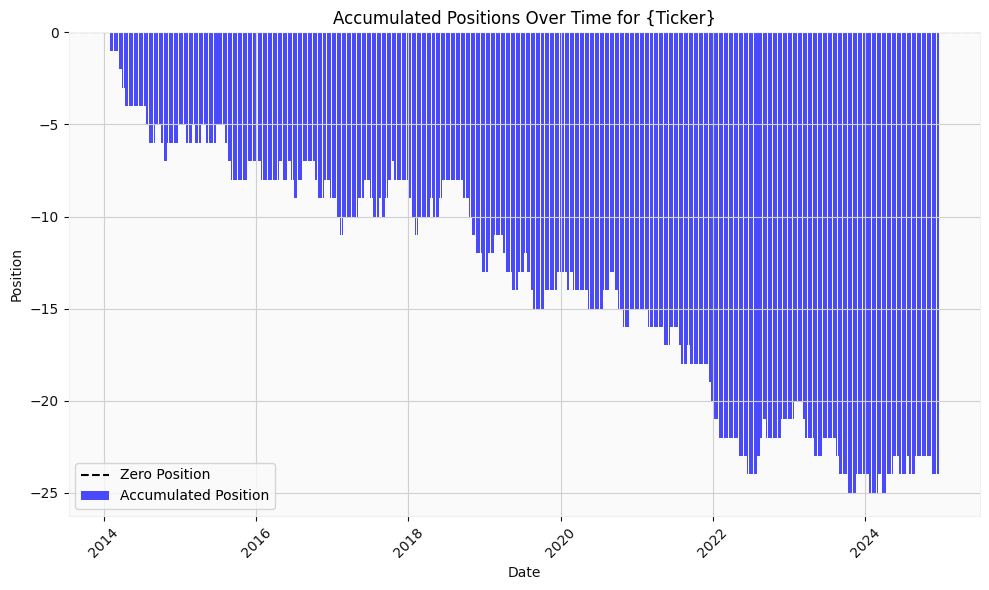

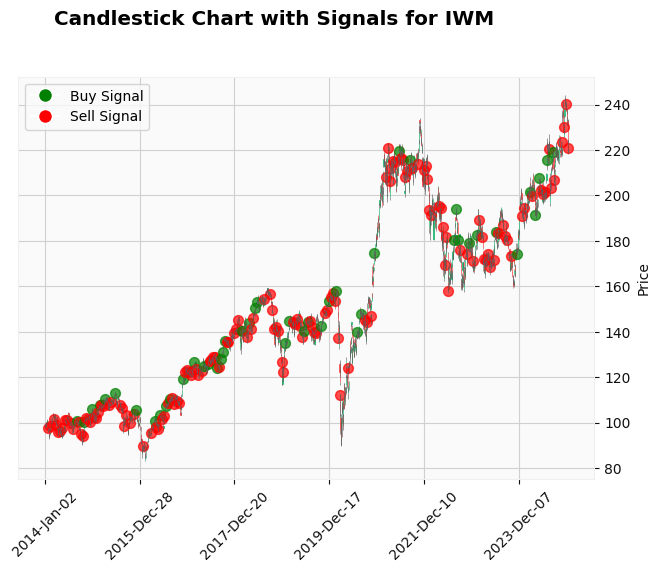

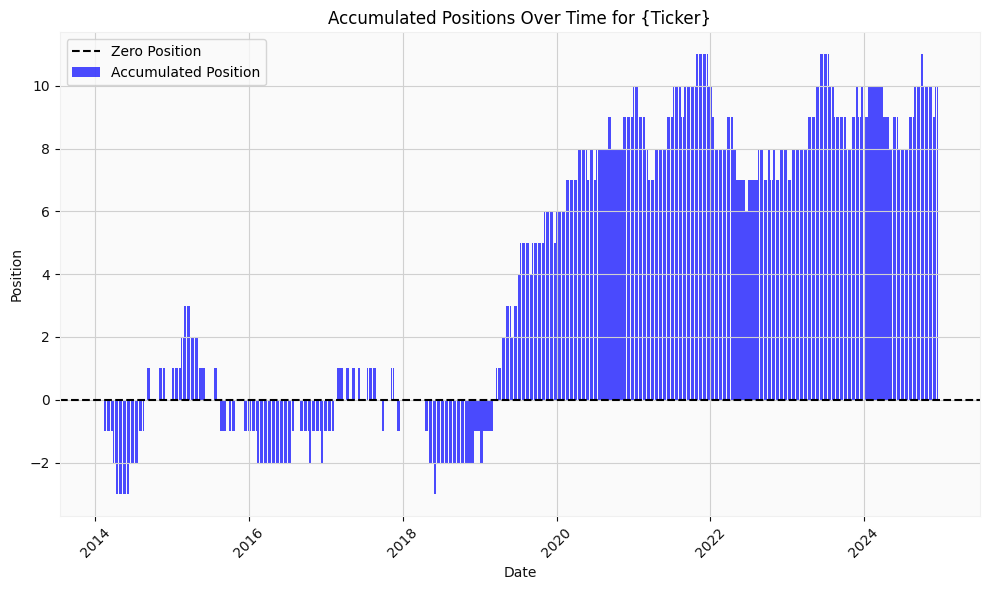

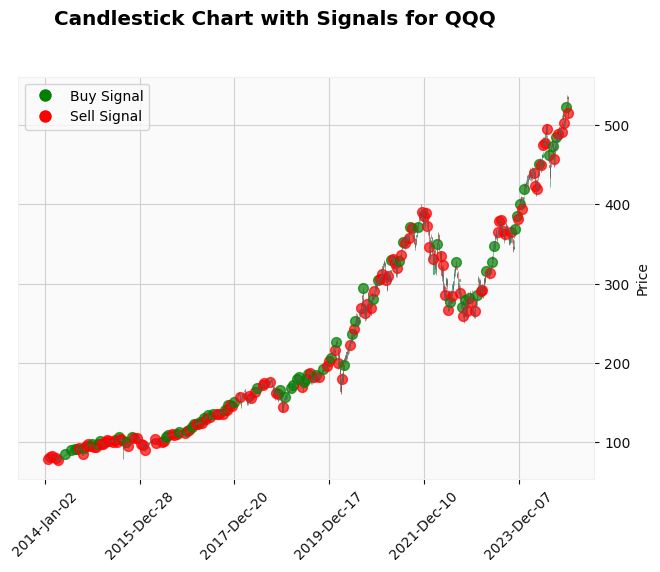

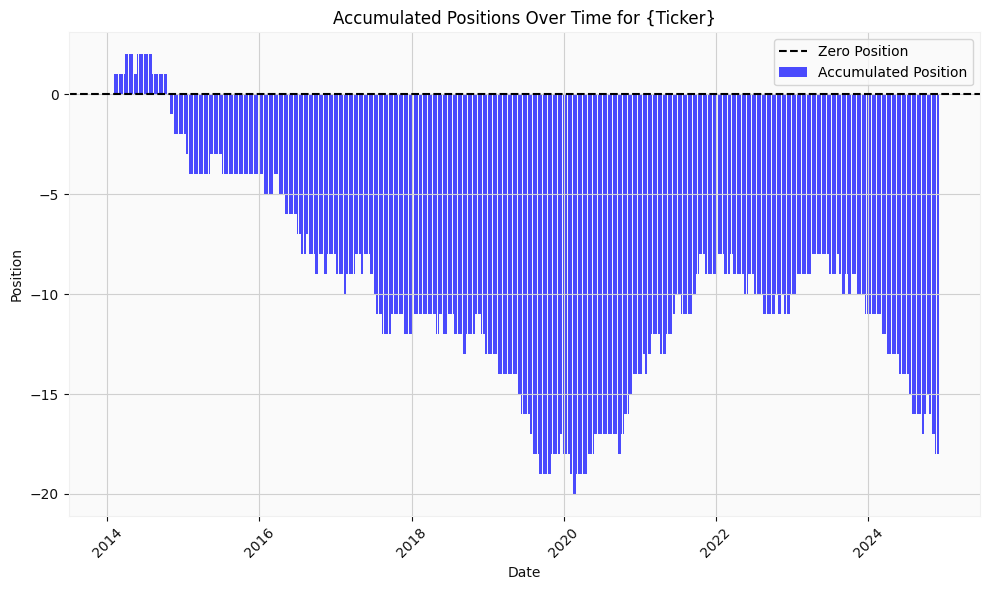

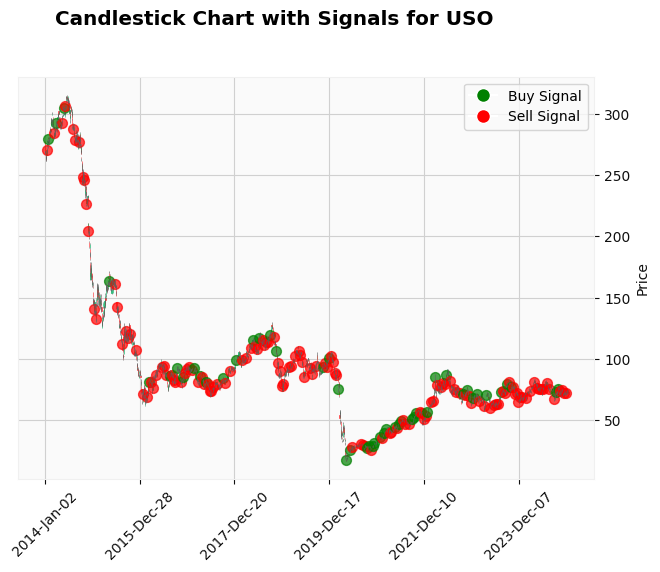

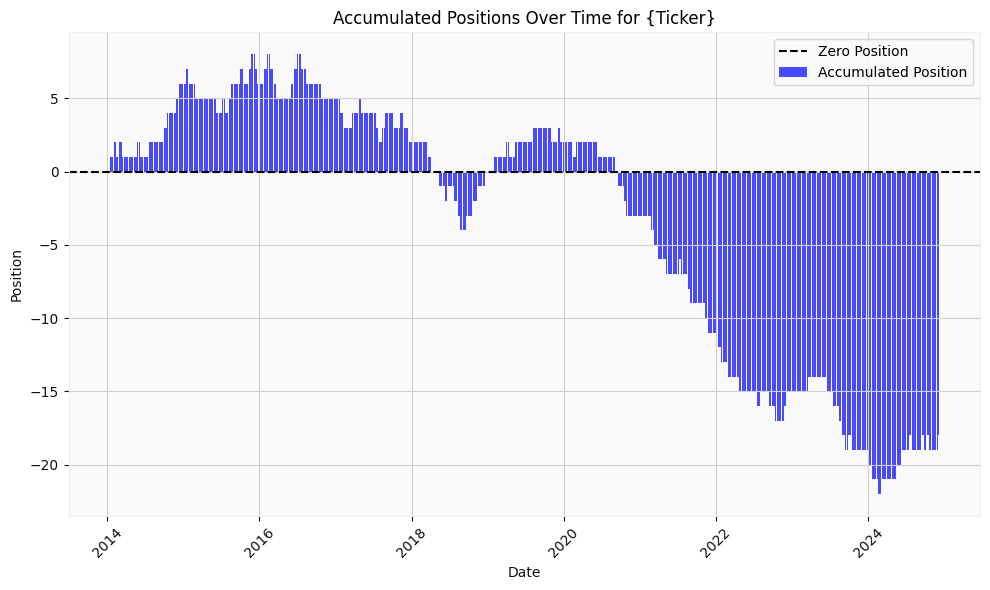

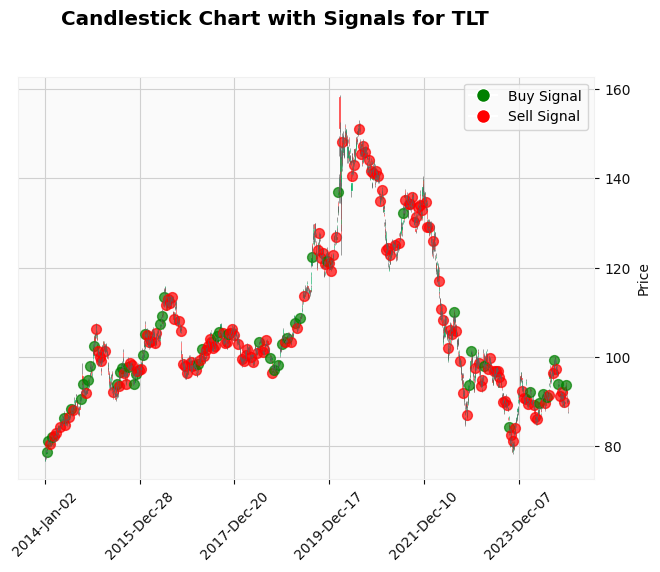

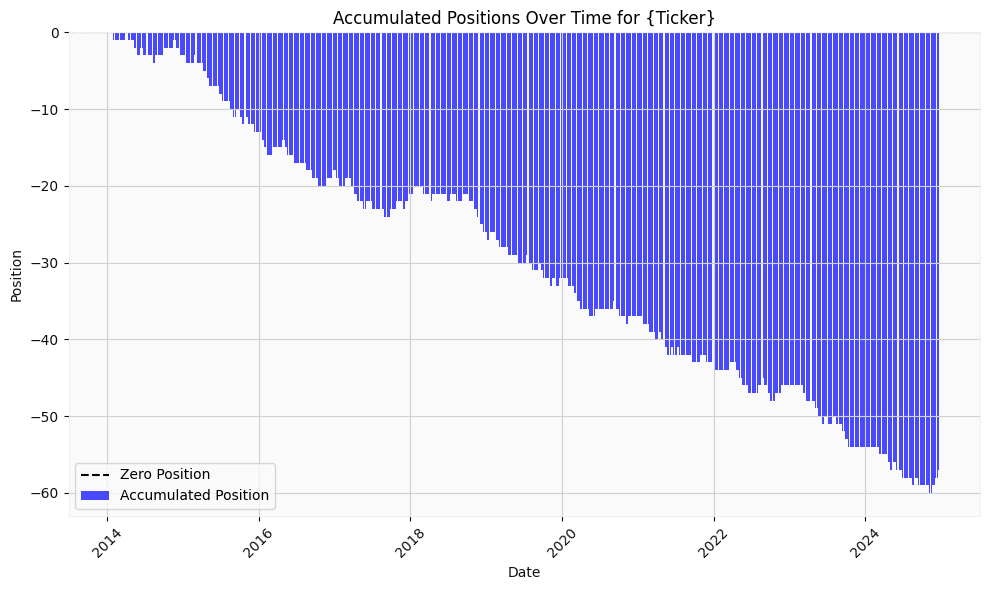

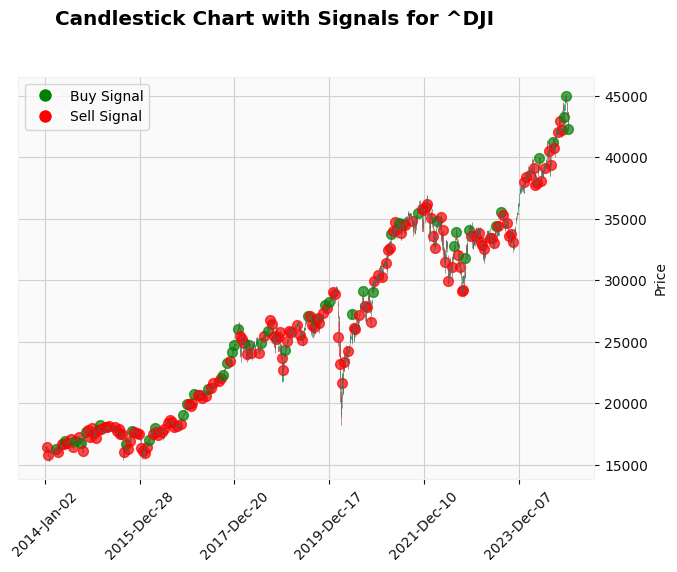

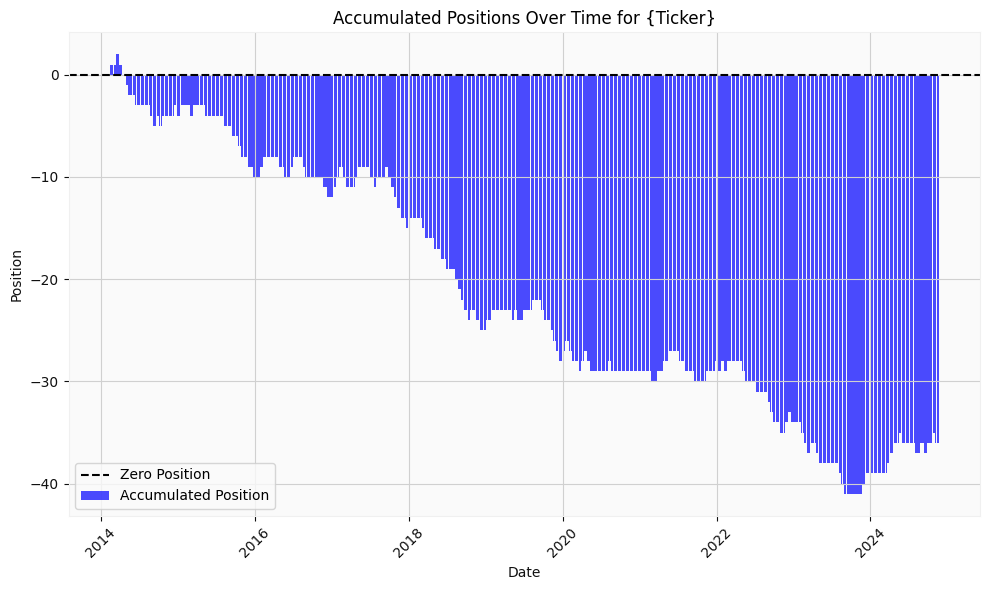

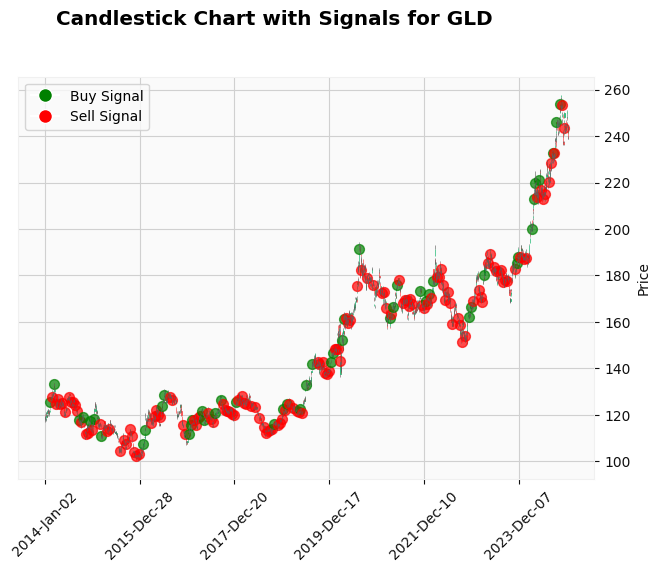

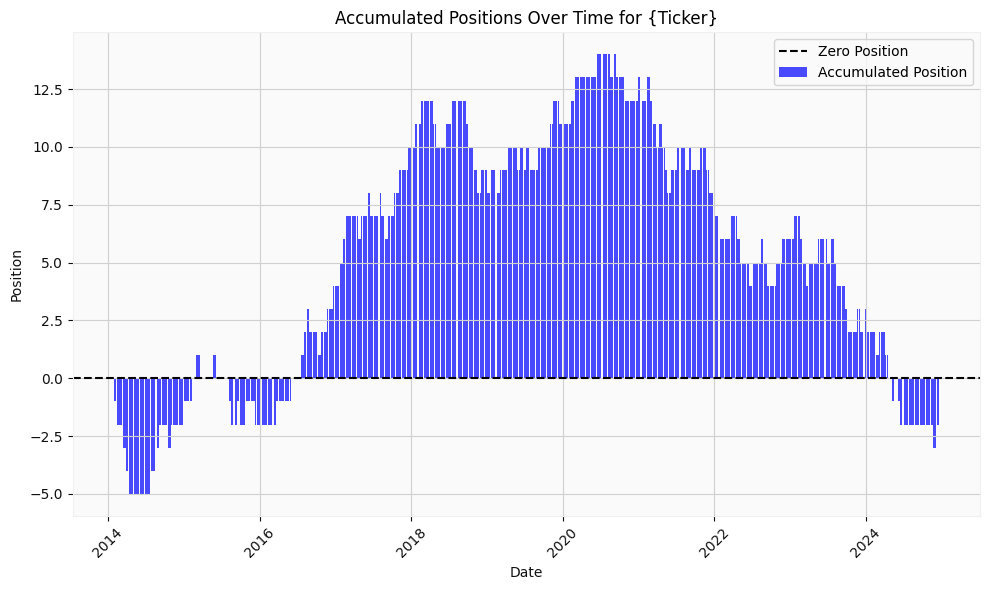

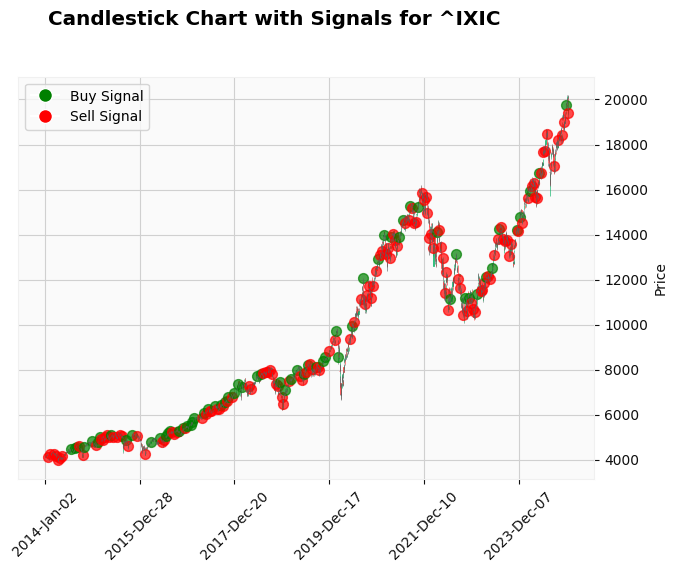

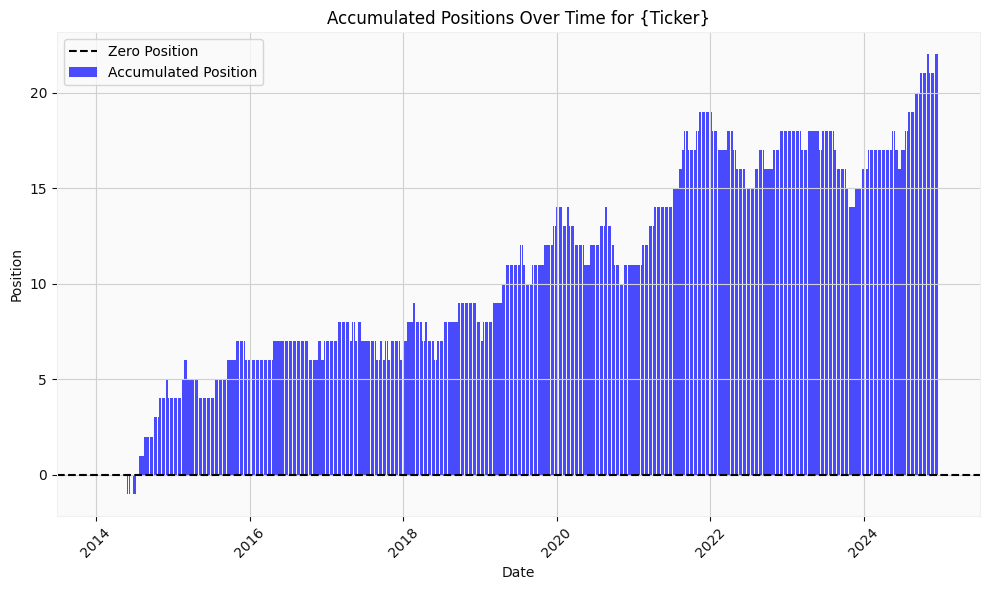

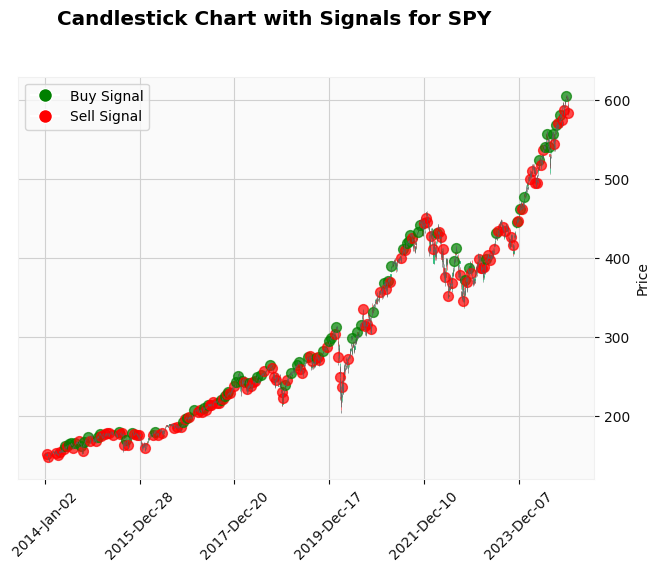

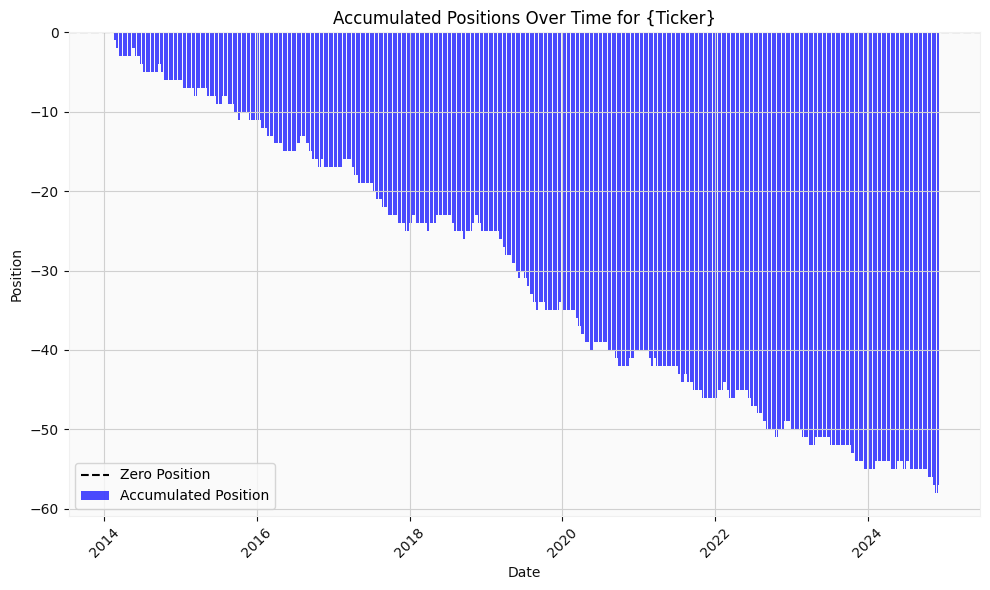

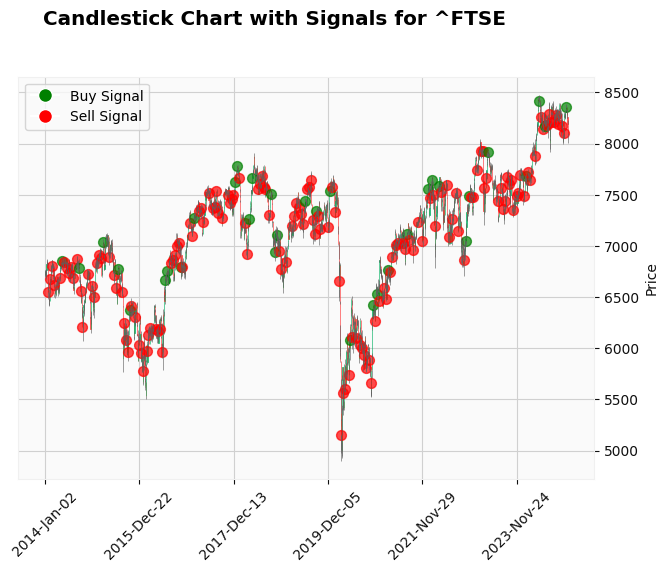

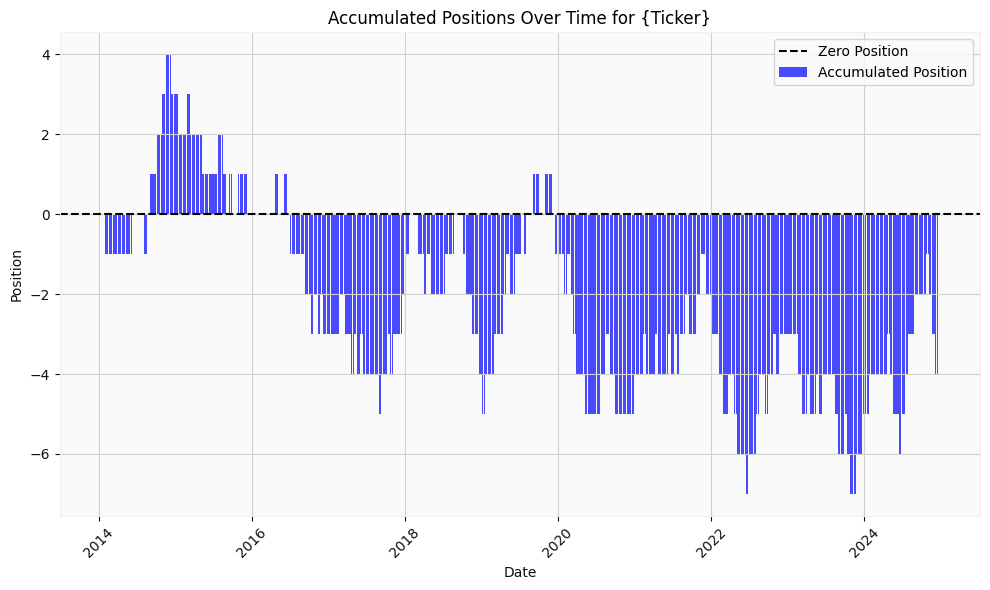

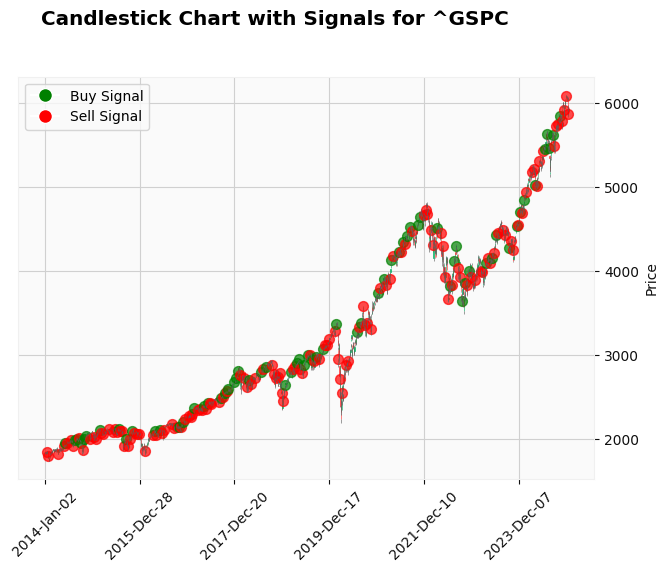

In [6]:

# directory maangement
DATA_FILE = "indices_etfs_dataset.csv"
CHARTS_DIR = "charts/candlestick3output"
LOG_FILE_PATH = "cnn_candlestick_debug.log"



#  output directory exists
os.makedirs(CHARTS_DIR, exist_ok=True)

def clean_log_file(log_file_path):
    """
    Clean the log file before starting a new logging session.

    """
    if os.path.exists(log_file_path):
        os.remove(log_file_path)
        print(f"Log file '{log_file_path}' cleaned.")
    else:
        print(f"Log file '{log_file_path}' does not exist. No cleaning needed.")

# implementation
if __name__ == "__main__":
   
    clean_log_file(LOG_FILE_PATH)

    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        filename=LOG_FILE_PATH,
        filemode="w",
        format="%(asctime)s - %(levelname)s - %(message)s"
    )
    logging.info("Starting main workflow.")

    
    df, tickers = load_dataset(DATA_FILE)

    # Debug: Limit tickers for demonstration
    #tickers = tickers[:2]
    logging.info(f"Processing the first {len(tickers)} tickers: {tickers}")

    pnl_results = [process_ticker(ticker, df, model, transform, device) for ticker in tickers]

    save_pnl_results(pnl_results, CHARTS_DIR)

    log_class_distribution(CHARTS_DIR, tickers)




Model Performance Metrics:
Accuracy: 60.01%
Precision: 0.80
Recall: 0.60
F1 Score: 0.48

Classification Report:
              precision    recall  f1-score   support

         Buy       0.95      0.93      0.94       562
    No_Trade       0.48      1.00      0.65       796
        Sell       1.00      0.00      0.01       845

    accuracy                           0.60      2203
   macro avg       0.81      0.64      0.53      2203
weighted avg       0.80      0.60      0.48      2203



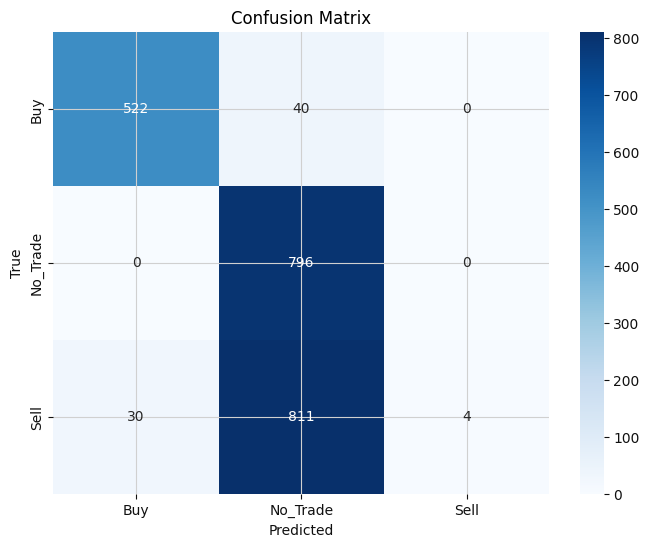

In [7]:


def test_model_accuracy(model, dataloader, device, class_mapping=None):
    """
    Test the model's accuracy on the validation dataset and handle class absence gracefully.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # default class mapping if not provided
    if class_mapping is None:
        class_mapping = {0: "Buy", 1: "No_Trade", 2: "Sell"}
    
    #  # {"Buy": 0, "No_Trade": 1, "Sell": 2} for it to work with sklearn metrics
    # sklearn.metrics.classification_report expects class indices as integers

    reverse_mapping = {v: k for k, v in class_mapping.items()}
    target_names = list(class_mapping.values())

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, labels=list(reverse_mapping.values()), average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, labels=list(reverse_mapping.values()), average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, labels=list(reverse_mapping.values()), average='weighted', zero_division=0)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=list(reverse_mapping.values()), target_names=target_names, zero_division=0))

    
    cm = confusion_matrix(all_labels, all_preds, labels=list(reverse_mapping.values()))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

validation_dataset = datasets.ImageFolder(root=CHARTS_DIR, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


test_model_accuracy(model, validation_loader, device)

